## 프로젝트: CutMix 또는 Mixup 비교실험 하기

지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 데이터를 확인해보면,

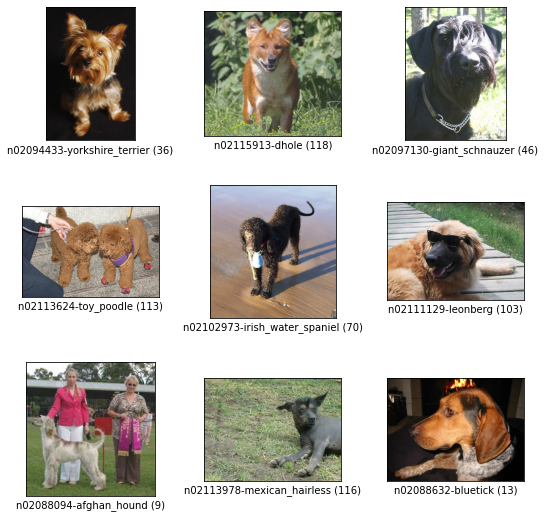

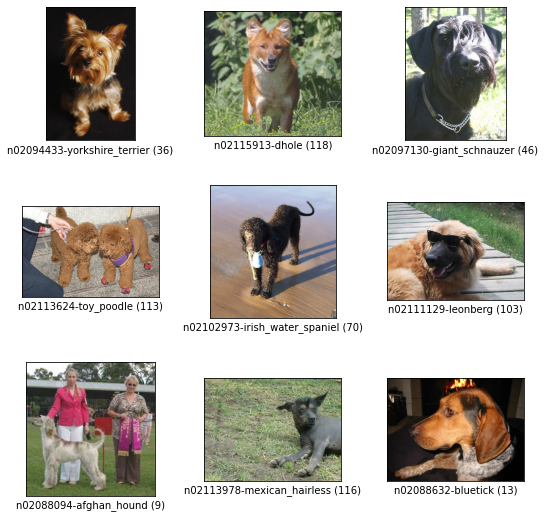

In [5]:
tfds.show_examples(ds_train, ds_info)

**1. Augmentation을 적용한 데이터셋 만들기**

이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

CutMix에 필요한 함수

In [6]:
# cutmix augmentation - 이미지 섞기
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)

    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max,0:x_min,:]
    middle_center = image_b[y_min:y_max,x_min:x_max,:]
    middle_right = image_a[y_min:y_max,x_max:image_size_x,:]
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min,:,:]
    bottom = image_a[y_max:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

# cutmix augmentation - 라벨 섞기
# mix two labels
def mix_2_labels(image_a,image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120): # image_a, image_b 넣어주기!!
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


mix_2_labels()에서 자꾸 오류가 발생했다.

    해결방안 : 노드와 다르게 image_a를 변수로 넣어주어야한다.

Mixup에 필요한 함수

In [7]:
# Mixup Augmentation
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

#구현한 함수를 활용하여 배치 단위의 mixup() 함수
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


일반적인 전처리 과정

In [8]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# augment 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# 전체적인 전처리 과정
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


**2. 모델 만들기**

앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

augmentation을 적용하지 않은 데이터셋으로 학습시킬 ResNet

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # 이미지넷과 다른 클래스 구조를 가지므로
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


augmentation을 적용한 데이터셋으로 학습시킬 ResNet

In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


augmentation + Cutmix을 적용한 데이터셋으로 학습시킬 ResNet

In [11]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


augmentation + Mixup을 적용한 데이터셋으로 학습시킬 ResNet

In [12]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False) # aug 하지 않는다
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
df_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
df_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


**3. 모델 훈련하기**

모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!
    
    => 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

In [14]:
EPOCH = 30  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


750/750 [==============================] - 168s 208ms/step - loss: 2.2012 - accuracy: 0.4493 - val_loss: 3.4542 - val_accuracy: 0.1924
Epoch 2/30
750/750 [==============================] - 155s 207ms/step - loss: 0.7830 - accuracy: 0.7834 - val_loss: 1.1854 - val_accuracy: 0.6554
Epoch 3/30
750/750 [==============================] - 155s 207ms/step - loss: 0.2886 - accuracy: 0.9326 - val_loss: 0.9856 - val_accuracy: 0.7141
Epoch 4/30
750/750 [==============================] - 155s 207ms/step - loss: 0.0844 - accuracy: 0.9902 - val_loss: 0.9171 - val_accuracy: 0.7372
Epoch 5/30
750/750 [==============================] - 155s 207ms/step - loss: 0.0324 - accuracy: 0.9977 - val_loss: 0.9166 - val_accuracy: 0.7383
Epoch 6/30
750/750 [==============================] - 155s 206ms/step - loss: 0.0180 - accuracy: 0.9995 - val_loss: 0.9135 - val_accuracy: 0.7450
Epoch 7/30
750/750 [==============================] - 155s 206ms/step - loss: 0.0122 - accuracy: 0.9996 - val_loss: 0.9256 - val_accura

In [15]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 163s 207ms/step - loss: 2.2632 - accuracy: 0.4327 - val_loss: 2.5254 - val_accuracy: 0.3448
Epoch 2/30
750/750 [==============================] - 169s 226ms/step - loss: 0.9313 - accuracy: 0.7322 - val_loss: 1.3337 - val_accuracy: 0.6188
Epoch 3/30
750/750 [==============================] - 155s 207ms/step - loss: 0.4991 - accuracy: 0.8662 - val_loss: 1.2349 - val_accuracy: 0.6519
Epoch 4/30
750/750 [==============================] - 154s 206ms/step - loss: 0.2569 - accuracy: 0.9417 - val_loss: 0.9691 - val_accuracy: 0.7149
Epoch 5/30
750/750 [==============================] - 154s 206ms/step - loss: 0.1382 - accuracy: 0.9752 - val_loss: 1.0527 - val_accuracy: 0.7063
Epoch 6/30
750/750 [==============================] - 155s 206ms/step - loss: 0.0871 - accuracy: 0.9869 - val_loss: 0.9980 - val_accuracy: 0.7241
Epoch 7/30
750/750 [==============================] - 154s 206ms/step - loss: 0.0494 - accuracy: 0.9942 - val_loss: 1.0860 -

In [16]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 163s 207ms/step - loss: 2.2866 - accuracy: 0.4288 - val_loss: 2.7789 - val_accuracy: 0.3066
Epoch 2/30
750/750 [==============================] - 169s 226ms/step - loss: 0.9337 - accuracy: 0.7306 - val_loss: 1.1706 - val_accuracy: 0.6567
Epoch 3/30
750/750 [==============================] - 155s 206ms/step - loss: 0.4955 - accuracy: 0.8680 - val_loss: 1.1667 - val_accuracy: 0.6665
Epoch 4/30
750/750 [==============================] - 154s 206ms/step - loss: 0.2743 - accuracy: 0.9348 - val_loss: 1.1118 - val_accuracy: 0.6811
Epoch 5/30
750/750 [==============================] - 155s 206ms/step - loss: 0.1494 - accuracy: 0.9709 - val_loss: 1.0064 - val_accuracy: 0.7179
Epoch 6/30
750/750 [==============================] - 155s 206ms/step - loss: 0.0823 - accuracy: 0.9869 - val_loss: 1.0160 - val_accuracy: 0.7158
Epoch 7/30
750/750 [==============================] - 155s 206ms/step - loss: 0.0513 - accuracy: 0.9932 - val_loss: 0.9652 -

In [17]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 162s 207ms/step - loss: 2.2685 - accuracy: 0.4363 - val_loss: 3.2433 - val_accuracy: 0.2332
Epoch 2/30
750/750 [==============================] - 154s 206ms/step - loss: 0.9470 - accuracy: 0.7253 - val_loss: 1.3143 - val_accuracy: 0.6269
Epoch 3/30
750/750 [==============================] - 170s 226ms/step - loss: 0.4887 - accuracy: 0.8704 - val_loss: 1.0557 - val_accuracy: 0.6967
Epoch 4/30
750/750 [==============================] - 156s 207ms/step - loss: 0.2624 - accuracy: 0.9376 - val_loss: 1.0335 - val_accuracy: 0.7034
Epoch 5/30
750/750 [==============================] - 154s 206ms/step - loss: 0.1403 - accuracy: 0.9711 - val_loss: 1.0175 - val_accuracy: 0.7085
Epoch 6/30
750/750 [==============================] - 155s 207ms/step - loss: 0.0791 - accuracy: 0.9892 - val_loss: 1.1188 - val_accuracy: 0.7007
Epoch 7/30
750/750 [==============================] - 155s 207ms/step - loss: 0.0495 - accuracy: 0.9942 - val_loss: 1.0780 -

**4. 훈련 과정 시각화하기**

훈련 과정의 히스토리를 그래프로 시각화해 주세요.

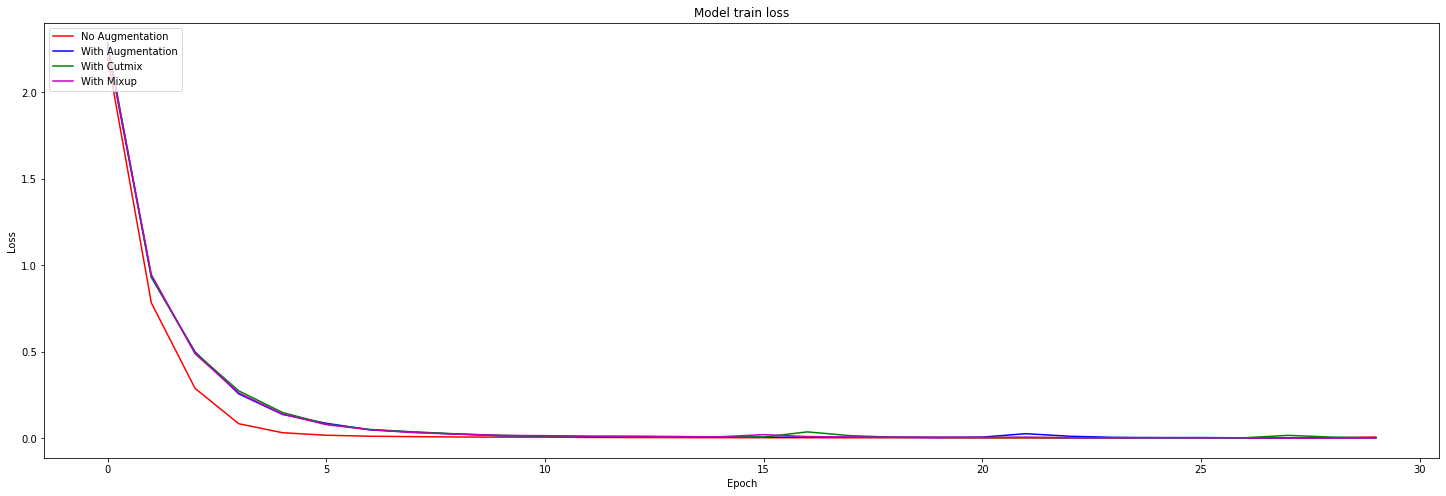

In [30]:
fig = plt.figure(figsize=(25,8))

plt.subplot(1, 1, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'm')
plt.title('Model train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

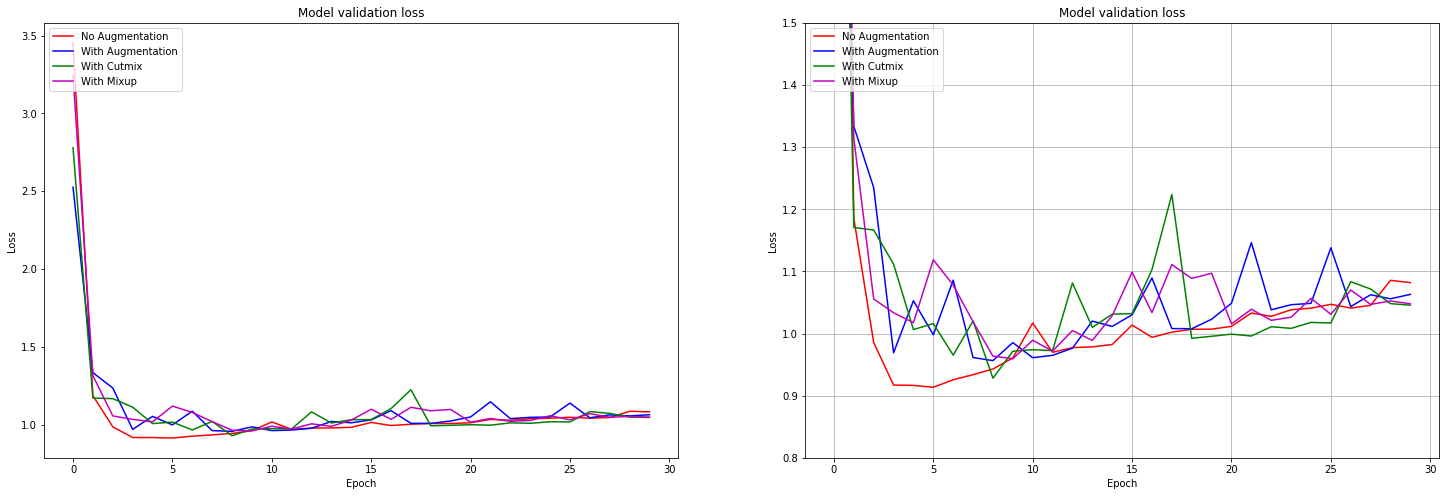

In [27]:
fig = plt.figure(figsize=(25,8))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'm')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'm')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.8, 1.5)
plt.show()

**5. Augmentation에 의한 모델 성능 비교**

No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

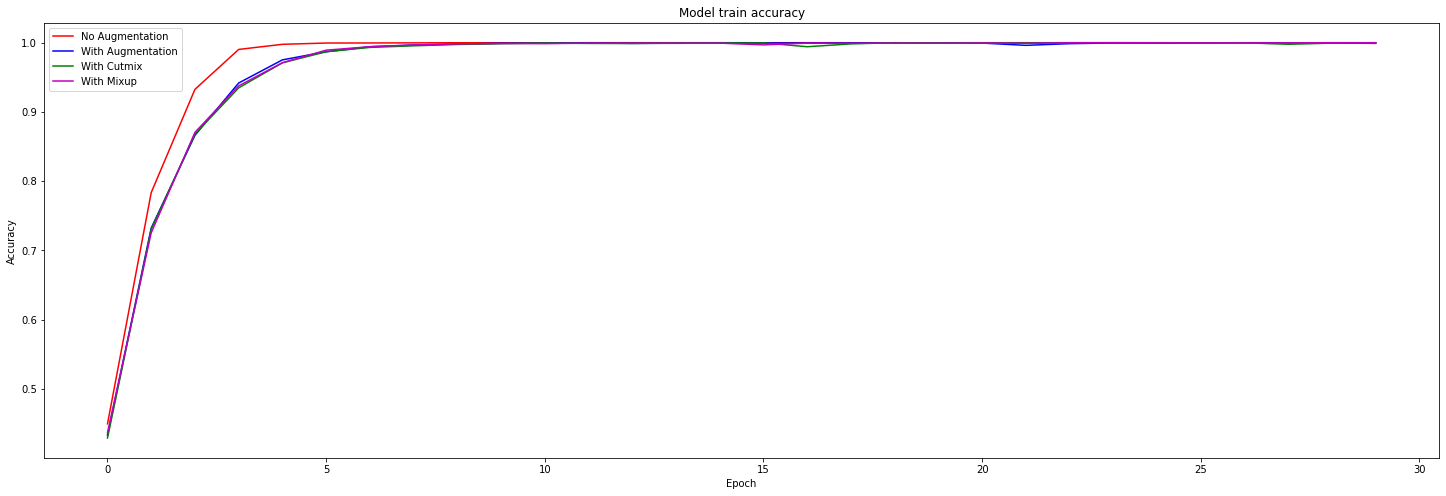

In [29]:
fig = plt.figure(figsize=(25,8))

plt.subplot(1, 1, 1)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'm')
plt.title('Model train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

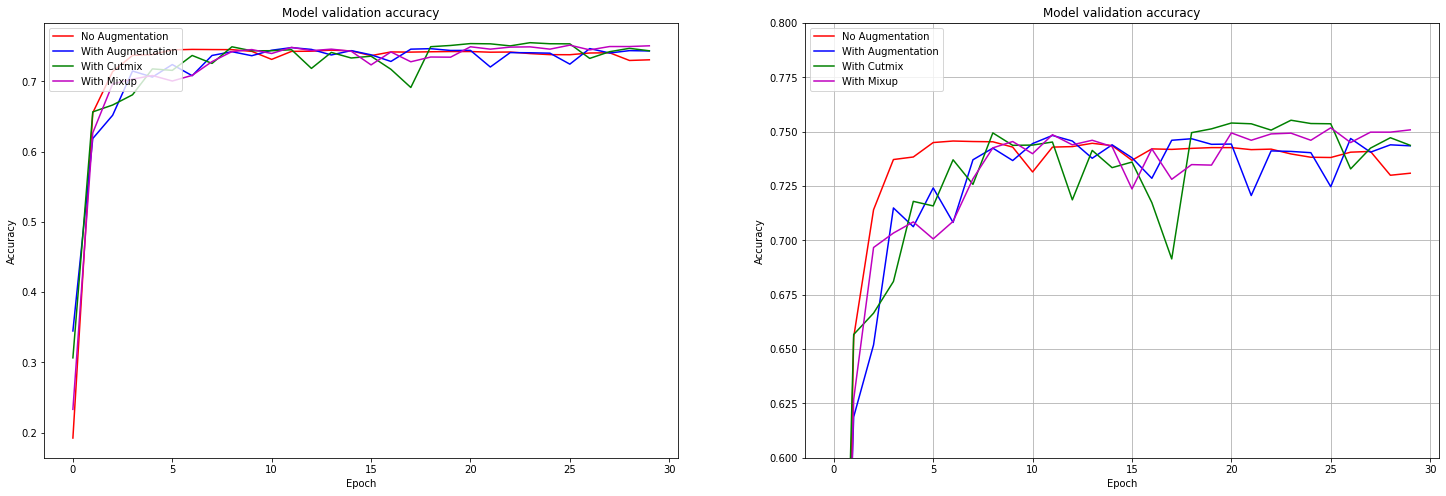

In [19]:
fig = plt.figure(figsize=(25,8))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.80)
plt.show()

처음 시도했을 때,

에폭 20일 경우, 가장 성능이 좋은 경우는 아래와 같다.

**No Augmentation**

Epoch 8/20

750/750 [==============================] - 175s 233ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.9437 - val_accuracy: 0.7444

**기본 Augmentation**

Epoch 15/20

750/750 [==============================] - 174s 231ms/step - loss: 0.0084 - accuracy: 0.9996 - val_loss: 0.9745 - val_accuracy: 0.7543

**기본 + CutMix**

Epoch 10/20

750/750 [==============================] - 161s 214ms/step - loss: 0.0164 - accuracy: 0.9990 - val_loss: 0.9487 - val_accuracy: 0.7494

**기본 + Mixup**

Epoch 20/20

750/750 [==============================] - 173s 231ms/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.9976 - val_accuracy: 0.7543

**기본 + Mixup >= 기본 Augmentation > 기본 + CutMix > No Augmentation** 순으로 성능이 좋음을 확인 할 수 있다.

***
에폭 30으로 다시 돌려보니,

**No Augmentation**

Epoch 7/30

750/750 [==============================] - 155s 206ms/step - loss: 0.0122 - accuracy: 0.9996 - val_loss: 0.9256 - val_accuracy: 0.7457

**기본 Augmentation**

Epoch 12/30

750/750 [==============================] - 155s 206ms/step - loss: 0.0096 - accuracy: 0.9996 - val_loss: 0.9649 - val_accuracy: 0.7483

**기본 + CutMix**

Epoch 24/30

750/750 [==============================] - 154s 206ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.0083 - val_accuracy: 0.7552

**기본 + Mixup**

Epoch 30/30

750/750 [==============================] - 156s 208ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0479 - val_accuracy: 0.7508

**기본 + CutMix > 기본 + Mixup > 기본 Augmentation > No Augmentation** 순으로 성능이 좋음을 확인 할 수 있다.

***
## 회고

이 프로젝트를 통해 Augmentation이 실제 성능 향상에 도움을 줄 수 있다는 것을 알 수 있었다.

kernel이 죽는 문제가 많아서 에폭 별로 가중치와 history 결과를 저장해두는 코드를 활용해서 진행해야겠다.

```
def get_history_from_path(path):
    epoch = []
    loss = []
    accuracy = []
    val_loss = []
    val_accuracy = []

    for i in os.listdir(path):
    if '.h5' in i:
        result = i[4:-3].split('-')

    epoch.append(float(i[:2]))
    loss.append(float(result[0]))
    accuracy.append(float(result[1]))
    val_loss.append(float(result[2]))
    val_accuracy.append(float(result[3]))

    history = pd.DataFrame()
    history['epoch'] = epoch
    history['loss'] = loss
    history['accuracy'] = accuracy
    history['val_loss'] = val_loss
    history['val_accuracy'] = val_accuracy

    history.sort_values(by='epoch', inplace=True)
    history.reset_index(inplace=True, drop=True)

    return history
```